<a href="https://colab.research.google.com/github/wh1t3tea/VoiceVeirification/blob/main/Augmentation_Treshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install speechbrain
!pip install audiomentations

In [ ]:
!pip install torch-audiomentations

In [ ]:
import torch
import torchaudio
from librosa import load, resample
from speechbrain.pretrained import EncoderClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchaudio import datasets
from torch_audiomentations import Compose, AddBackgroundNoise, PitchShift, TimeInversion, PolarityInversion, Gain
from IPython.display import Audio

In [ ]:
apply_augmentation = Compose(
    transforms=[
        Gain(
            min_gain_in_db=-15.0,
            max_gain_in_db=5.0,
            p=0.5,
        ),
        PolarityInversion(p=0.5),
        AddBackgroundNoise(background_paths="/content/drive/MyDrive/audio",
                            min_snr_in_db=3.0,
                            max_snr_in_db=10.0,
                            target_rate=16000,
                            p=1.0),
        PitchShift(min_transpose_semitones=-2, max_transpose_semitones=2, p=0.5, sample_rate=16000),
    ]
)



In [ ]:
# Testing augmentation pipeline
example = torch.tensor(data=load('/content/drive/MyDrive/Голос.mp3', sr=16000)[0], dtype=torch.float32).to('cuda')

augmented_example = apply_augmentation(example.reshape(1, 1, len(example)), sample_rate=16000)

In [ ]:
from IPython.utils.text import num_ini_spaces
def get_augmented_wav(wav, wav_sr):
  augmented_example = apply_augmentation(wav.reshape(1, 1, len(wav)), sample_rate=wav_sr)
  example = augmented_example.squeeze(0).squeeze(0)
  return example

In [ ]:
wav_1 = example
wav_2 = play_wav(wav_1, 16000)

In [ ]:
wav_1.shape, wav_2.shape

(torch.Size([160000]), torch.Size([160000]))

In [ ]:
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")

In [ ]:
# @title Функция для рассчета косинусового расстояния между векторами (эмбеллингами)
'''На данном этапе, treshold был выбран 0.38'''


def count_cosine_distance(wav_1, wav_2, sr):
  embedding_1 = classifier.encode_batch(wav_1).reshape(192).to('cuda')
  embedding_2 = classifier.encode_batch(wav_2).reshape(192).to('cuda')

  cosine_dist = scipy.spatial.distance.cosine(embedding_1, embedding_2)
  if cosine_dist < 0.38:
    pred = True
  else:
    pred = False
  return cosine_dist, pred


In [ ]:
count_cosine_distance(wav_1, wav_2, 16000)

(0.07607877254486084, True)

In [ ]:
# @title Функция для создания датасета из аугментированных данных (на валидацию)

def augmented_datagen(wav, num_examples, sr=16000):
  augmented_data = []

  for epoch in range(num_examples):

    aug_audio = get_augmented_wav(wav, sr)
    augmented_data.append(aug_audio)

  return augmented_data

In [ ]:
augmented_data = augmented_datagen(example, 500)

In [ ]:
preds = []
for epoch in range(len(augmented_data)):
  dist, pred = count_cosine_distance(wav_1, augmented_data[epoch], 16000)
  preds.append(pred)

In [ ]:
preds.count(True)

500

In [ ]:
import os

In [ ]:
'''Данные негативного класса взяты из открытого датасета common_voice_ru'''

negative_data = []

data_path = '/content/drive/MyDrive/false_data'

for filename in os.listdir(data_path)[:1000]:
  filepath = os.path.join(data_path, filename)
  wav = torch.tensor(data=load(filepath, sr=16000)[0], dtype=torch.float32).to('cuda')
  negative_data.append(wav)

In [ ]:
''' Создаются лейблы для вычисления accuracy score модели '''

labels = np.array([1] * 500 + [0] * 1000)

In [ ]:
len(labels), labels.shape

(1500, (1500,))

In [ ]:
len(negative_data), negative_data[0]

(1000,
 tensor([-4.3201e-12, -7.2760e-12,  0.0000e+00,  ...,  1.8190e-12,
          0.0000e+00,  1.8190e-12], device='cuda:0'))

In [ ]:
len(augmented_data), augmented_data[0]

(500,
 tensor([-0.0060,  0.0086,  0.0105,  ..., -0.0003, -0.0003, -0.0002],
        device='cuda:0'))

In [ ]:
validation_data = augmented_data + negative_data
len(validation_data), type(validation_data)

(1500, list)

In [ ]:
'''Сохранение данных на валидацию'''

torch.save(validation_data, f="/content/drive/MyDrive/validation data/data.pt")

In [ ]:
model_preds = []

for epoch in range(len(validation_data)):
  prediction = count_cosine_distance(wav_1, validation_data[epoch], 16000)

  model_preds.append(prediction)

In [ ]:
predictions = []
distances = []
for dist, pred in model_preds:
  distances.append(dist)
  if pred == True:
    predictions.append(1)
  else:
    predictions.append(0)

In [ ]:
accuracy_score(labels, predictions)

1.0

In [ ]:
''' Среднее косинусовое расстояние между вектором таргета и векторами
    отнясищихся к негативному классу - 0.8188505178317428,
    а для представителей положительного класса - 0.1426826995611191.'''

np.array(distances[500:]).mean(), np.array(distances[:500]).mean()

0.1426826995611191

Text(0.5, 1.0, 'Dependence of labels on distance')

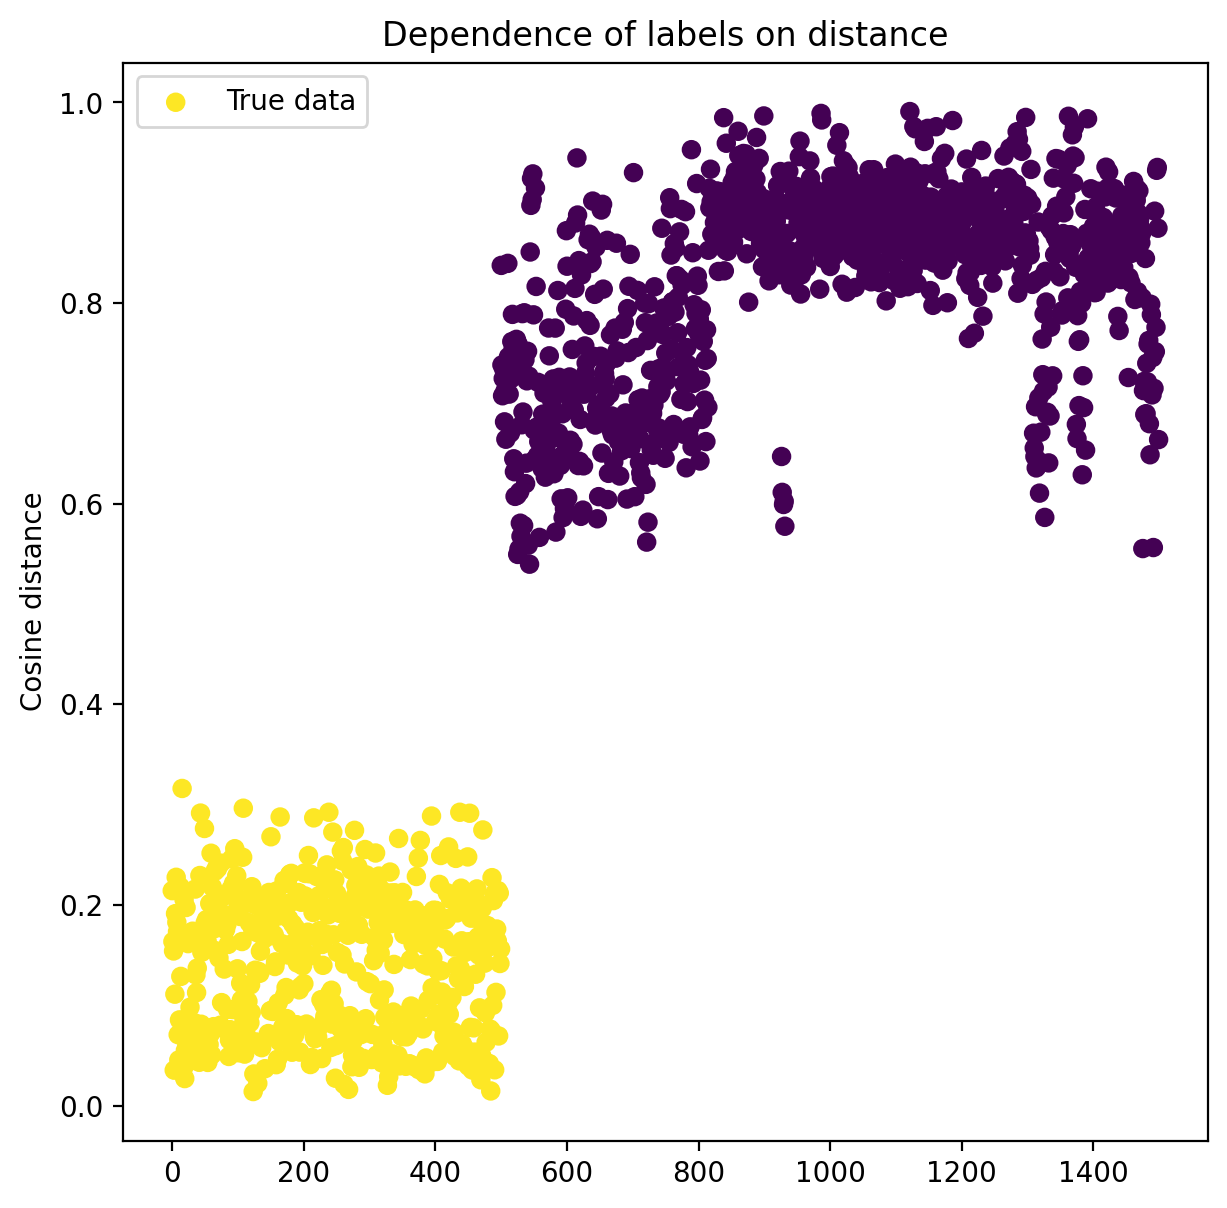

In [ ]:
plt.figure(figsize=(7, 7), dpi=200)
plt.scatter(range(1500), distances, c=predictions)
plt.ylabel('Cosine distance')
plt.legend(['True data', 'False data'])
plt.title('Dependence of labels on distance')

In [ ]:
'''Точность модели при treshold = 0.38 на данной выборке составила 100%.
   Такой высокий результат может быть вызван тем,
   что схожесть валидационных данных и голоса таргета недостаточна высока.
   В таком случае стоит попробовать подобрать более подходящие данные
   для негативного класса.'''

In [ ]:
example = torch.tensor(data=load('/content/drive/MyDrive/000bf0cd-75f4-4086-92b9-da6bcd199aec.mp3', sr=16000)[0], dtype=torch.float32).to('cuda')
count_cosine_distance_th(target_voice, example, 16000, 0.38)

(0.7040590941905975, False)

In [ ]:
''' Для удобства при дальнейших эксперементах с пороговым значением в аргументы функции добавлен treshold'''

def count_cosine_distance_th(wav_1, wav_2, sr, treshold, classifier=classifier):
  embedding_1 = classifier.encode_batch(wav_1).reshape(192).to('cpu')
  embedding_2 = classifier.encode_batch(wav_2).reshape(192).to('cpu')

  cosine_dist = scipy.spatial.distance.cosine(embedding_1, embedding_2)
  if cosine_dist < treshold:
    pred = True
  else:
    pred = False
  return cosine_dist, pred

In [ ]:
data = torch.load('/content/drive/MyDrive/validation data/data.pt')

In [ ]:
def validation(model_preds, labels):
  predictions = []
  distances = []
  for dist, pred in model_preds:
    distances.append(dist)
    if pred == True:
      predictions.append(1)
    else:
      predictions.append(0)
  return accuracy_score(labels, predictions)

In [ ]:
labels = np.array([1] * 500 + [0] * 1000)

In [ ]:
def model_predict(wav_1, data, treshold):
  model_preds = []

  for epoch in range(len(data)):
    prediction = count_cosine_distance_th(wav_1,
                                       data[epoch],
                                       16000,
                                       treshold)

    model_preds.append(prediction)
  return model_preds


In [ ]:
target_voice = torch.tensor(data=load('/content/drive/MyDrive/Голос.mp3', sr=16000)[0],
                            dtype=torch.float32).to('cuda')

In [ ]:
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb",
                                            run_opts={"device":"cuda:0"})

(…)eleb/resolve/main/mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

(…)-voxceleb/resolve/main/label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

In [ ]:
''' При treshold=0.28'''
predictions = model_predict(target_voice, data, 0.28)
accuracy = validation(predictions, labels)

In [ ]:
accuracy_scores_th = {0.28:0.994, 0.3:1.0}

In [ ]:
accuracy_scores_th

{'0.38': 1.0, '0.28': 0.994}

In [ ]:
accuracy

0.994

In [ ]:
'''treshold=0.48'''
predictions = model_predict(target_voice, data, 0.48)
accuracy = validation(predictions, labels)
accuracy_scores_th[0.48] = accuracy
print(accuracy)

1.0


In [ ]:
'''treshold=0.58'''
predictions = model_predict(target_voice, data, 0.58)
accuracy = validation(predictions, labels)
accuracy_scores_th[0.58] = accuracy
print(accuracy)

0.992


In [ ]:
'''treshold=0.2'''
predictions = model_predict(target_voice, data, 0.2)
accuracy = validation(predictions, labels)
accuracy_scores_th[0.2] = accuracy
print(accuracy)

0.92


In [ ]:
'''treshold=0.3'''
predictions = model_predict(target_voice, data, 0.3)
accuracy = validation(predictions, labels)
accuracy_scores_th[0.3] = accuracy
print(accuracy)

0.9993333333333333


In [ ]:
'''treshold=0.4'''
predictions = model_predict(target_voice, data, 0.4)
accuracy = validation(predictions, labels)
accuracy_scores_th[0.4] = accuracy
print(accuracy)

1.0


In [ ]:
'''treshold=0.5'''
predictions = model_predict(target_voice, data, 0.5)
accuracy = validation(predictions, labels)
accuracy_scores_th[0.5] = accuracy
print(accuracy)

1.0


In [ ]:
acc = np.array(sorted(accuracy_scores_th.items()))

Text(0, 0.5, 'Accuracy')

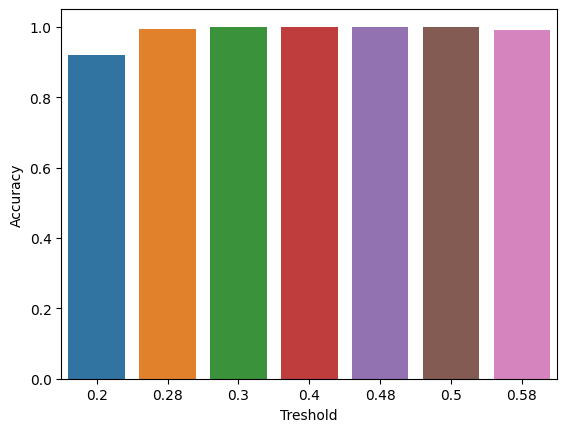

In [ ]:
sns.barplot(x=acc[:, 0], y=acc[:, 1])
plt.xlabel('Treshold')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

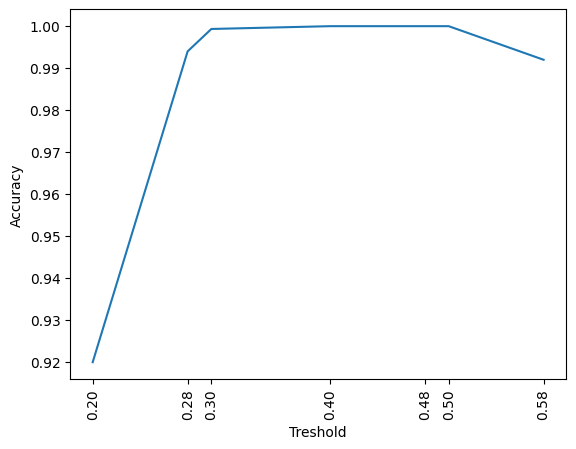

In [ ]:
sns.lineplot(x=acc[:, 0], y=acc[:, 1]);
plt.xticks(acc[:, 0], rotation=90);
plt.xlabel('Treshold')
plt.ylabel('Accuracy')

Как можно заметить по графикам точность максимальна при значениях
   treshold от 0.38 до 0.5
   Но так, как наша задача связана с верификацией следует в первую очередь
   минимизировать значение False Positive.
   Поэтому treshold для решения аналогичной реальной задачи следует выбирать из диапозона 0.38-0.4, так как
   при всех значениях от 0.38-0.5 точность достигла 1.0, но с поднятием
   treshold возрастает риск максимизировать количество FP значений.


Взятие значений treshold < 0.3 рекмоендуется только в тех случаях, когда ошибки FP недопустимы, так как модель может слишком часто не узнавать голос таргета. Взятие значений выше 0.4 может повлечь увеличение ошибок FN, но так как моя задача заключалась в максимизации общей точности, значение treshold будет взято 0.5



In [ ]:
import os
test_data = []
wrong_files = []
data_path = '/content/drive/MyDrive/test data/files'
for index, filename in enumerate(sorted(os.listdir(data_path))):
  try:
    exmpl = torch.tensor(data=load(os.path.join(data_path, filename), sr=16000)[0],
                        dtype=torch.float32).to('cuda')
    test_data.append([filename, exmpl])
  except Exception:
    wrong_files.append((filename, index))

In [ ]:
wrong_files

[('00bbc6d2-7536-4fa7-ae5e-31a1ed7a8d94.mp3', 270),
 ('00bf7ace-f3f9-4ecc-a6d6-3a4f66cbdfec.mp3', 278),
 ('0183d8f1-cdd5-4817-bbd4-cdb681cbdade.mp3', 562),
 ('01904186-aa75-4432-8604-02749a858570.mp3', 581)]

In [ ]:
print(wrong_files)

[('files', 0)]


In [ ]:
test_data

[]

In [ ]:
def model_predict_valid(wav_1, data, treshold):
  model_preds = []

  for epoch in range(len(data)):
    prediction = count_cosine_distance_th(wav_1,
                                       data[epoch][1],
                                       16000,
                                       treshold)

    model_preds.append(prediction)
  return model_preds


In [ ]:
test_preds = model_predict_valid(target_voice, test_data, 0.5)

In [ ]:
test_preds_labels = [1 if x == True else 0 for x in test_preds]

In [ ]:
info_lst = []
for index, value in enumerate(test_data):
  info_lst.append([test_preds[index], test_data[index]])

In [ ]:
distances = [x for x in info_lst if 0.4 < x[0][0] < 0.5]

In [ ]:
filenames = [x[1][0] for x in distances]

In [ ]:
preds = [x[1] for x in test_preds]

In [ ]:
preds.count(True)

250

In [ ]:
torch.save([1 if x == True else 0 for x in preds], f='/content/drive/MyDrive/preds/preds.pt')

In [ ]:
preds_txt = [1 if x == True else 0 for x in preds]

In [ ]:
import json

with open('/content/preds.txt', 'w') as fw:
    # записываем
    json.dump(preds_txt, fw)

In [4]:
mass = torch.load('/content/drive/MyDrive/preds/preds.pt')

In [9]:
from librosa import load

In [10]:
import os
test_data = []
wrong_files = []
data_path = '/content/drive/MyDrive/test data/files'
for index, filename in enumerate(sorted(os.listdir(data_path))):
  try:
    exmpl = torch.tensor(data=load(os.path.join(data_path, filename), sr=16000)[0],
                        dtype=torch.float32)
    test_data.append(filename)
  except Exception:
    wrong_files.append((filename, index))

<ipython-input-10-c7030e62c89d>:7: UserWarning: PySoundFile failed. Trying audioread instead.
  exmpl = torch.tensor(data=load(os.path.join(data_path, filename), sr=16000)[0],
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [14]:
for i in range(len(test_data)):
  mass[i] = f'{test_data[i]} {str(mass[i])}\n'

In [16]:
with open('/content/drive/MyDrive/finalpreds.txt', 'w') as f:
  for row in mass:
    f.write(row)
    f.write('\n')
